## NN2 Model for Fair Value Estimation

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN2_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN2_Decile_Signal = pd.DataFrame(index=list_company)
df_NN2_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN2_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN2 model
    model_nn2 = Sequential()
    model_nn2.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001), input_shape=(21,))) # Input layer
    model_nn2.add(Dropout(0.1))
    model_nn2.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001))) # hidden layer 1
    model_nn2.add(Dropout(0.2))
    model_nn2.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                        bias_regularizer=regularizers.l2(0.001))) # hidden layer 2
    model_nn2.add(Dropout(0.3))
    model_nn2.add(Dense(1, activation='linear')) # Output layer
    model_nn2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn2.fit(X_train, y_train, epochs=50, callbacks=[callback])
    y_fair = model_nn2.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN2_Quintile_Signal = df_NN2_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN2_Decile_Signal = df_NN2_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN2_20_Divided_Signal = df_NN2_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN2_Percentile_Signal = df_NN2_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [30]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN2_Quintile_Signal = pd.concat([df_199804_199809, df_NN2_Quintile_Signal, df_202206], axis=1)
df_NN2_Quintile_Signal = df_NN2_Quintile_Signal.fillna(0).T
df_NN2_Quintile_Signal = df_NN2_Quintile_Signal.shift(1).dropna()

df_NN2_Decile_Signal = pd.concat([df_199804_199809, df_NN2_Decile_Signal, df_202206], axis=1)
df_NN2_Decile_Signal = df_NN2_Decile_Signal.fillna(0).T
df_NN2_Decile_Signal = df_NN2_Decile_Signal.shift(1).dropna()

df_NN2_20_Divided_Signal = pd.concat([df_199804_199809, df_NN2_20_Divided_Signal, df_202206], axis=1)
df_NN2_20_Divided_Signal = df_NN2_20_Divided_Signal.fillna(0).T
df_NN2_20_Divided_Signal = df_NN2_20_Divided_Signal.shift(1).dropna()

df_NN2_Percentile_Signal = pd.concat([df_199804_199809, df_NN2_Percentile_Signal, df_202206], axis=1)
df_NN2_Percentile_Signal = df_NN2_Percentile_Signal.fillna(0).T
df_NN2_Percentile_Signal = df_NN2_Percentile_Signal.shift(1).dropna()

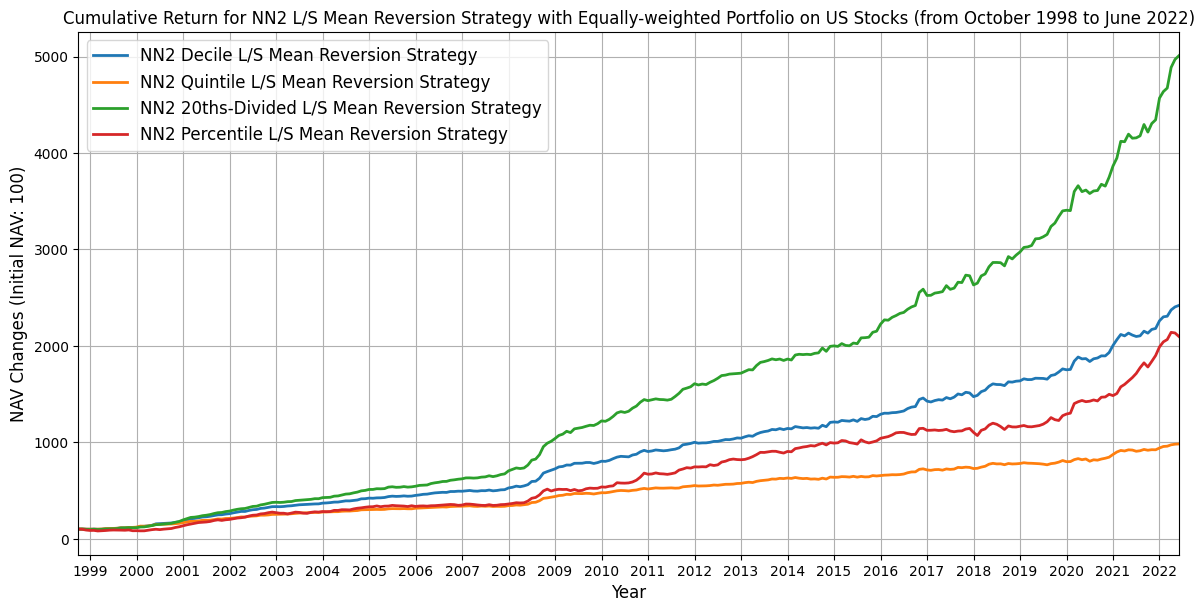

In [187]:
cum_NN2_Q_strategy_return = get_price_df(df_NN2_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN2_D_strategy_return = get_price_df(df_NN2_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN2_T_strategy_return = get_price_df(df_NN2_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN2_P_strategy_return = get_price_df(df_NN2_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN2_strategy_return = pd.concat([cum_NN2_D_strategy_return.rename('NN2 Decile L/S Mean Reversion Strategy'),
                                     cum_NN2_Q_strategy_return.rename('NN2 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN2_T_strategy_return.rename('NN2 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN2_P_strategy_return.rename('NN2 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN2_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN2 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)',
          fontsize=12)
plt.show()

In [224]:
# Performance Stats
stats_NN2_Q = get_performance_stats(cum_NN2_Q_strategy_return, rfr=risk_free_rate_df, label='NN2 Quintile (Initial NAV: 100)')
stats_NN2_D = get_performance_stats(cum_NN2_D_strategy_return, rfr=risk_free_rate_df, label='NN2 Decile (Initial NAV: 100)')
stats_NN2_T = get_performance_stats(cum_NN2_T_strategy_return, rfr=risk_free_rate_df, label='NN2 20ths (Initial NAV: 100)')
stats_NN2_P = get_performance_stats(cum_NN2_P_strategy_return, rfr=risk_free_rate_df, label='NN2 Percentile (Initial NAV: 100)')
NN2_stats = pd.concat([stats_NN2_Q, stats_NN2_D, stats_NN2_T, stats_NN2_P], axis=0)
display(NN2_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN2 Quintile (Initial NAV: 100),10.388719,0.107856,0.018682,0.051103,1.744966,1.316263,4.626609,1138.871882,2022-06-30,0.043331,2018-10-31,2019-08-31,2019-12-31,426
NN2 Decile (Initial NAV: 100),25.364903,0.147711,0.018682,0.057262,2.253324,0.683546,3.337130,2636.490328,2022-06-30,0.023704,2021-05-31,2021-07-31,2021-09-30,122
NN2 20ths (Initial NAV: 100),47.490823,0.177539,0.018682,0.064869,2.448868,0.407527,3.884439,4849.082330,2022-06-30,0.033772,2017-12-31,2018-01-31,2018-04-30,120
NN2 Percentile (Initial NAV: 100),29.595633,0.154926,0.018682,0.095372,1.428553,-0.271155,4.006110,3059.563286,2022-06-30,0.078458,2015-03-31,2015-07-31,2016-03-31,366


In [225]:
stats2_NN2_Q = get_performance_stats_2(df_NN2_Quintile_Signal, df_returns, df_market_cap, label='NN2 Quintile', model_type='ML')
stats2_NN2_D = get_performance_stats_2(df_NN2_Decile_Signal, df_returns, df_market_cap, label='NN2 Decile', model_type='ML')
stats2_NN2_T = get_performance_stats_2(df_NN2_20_Divided_Signal, df_returns, df_market_cap, label='NN2 20ths', model_type='ML')
stats2_NN2_P = get_performance_stats_2(df_NN2_Percentile_Signal, df_returns, df_market_cap, label='NN2 Percentile', model_type='ML')
NN2_stats2 = pd.concat([stats2_NN2_Q, stats2_NN2_D, stats2_NN2_T, stats2_NN2_P], axis=0)
display(NN2_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
NN2 Quintile (Long & Short),10.388719,0.008572,3.251328e+10,0.689655,0.090975,-0.076935,0.506494,0.521331,0.493993,464.286207
(Long Position),1118.202751,0.024939,1.655647e+09,0.706897,0.102203,-0.073423,0.568652,0.589135,0.551642,226.924138
(Short Position),-0.941133,-0.009889,6.108494e+10,0.379310,0.063942,-0.070457,0.449196,0.459767,0.440170,243.268966
NN2 Decile (Long & Short),25.364903,0.011547,4.900787e+10,0.755172,0.090896,-0.073278,0.517024,0.536302,0.500915,325.862069
(Long Position),5984.259183,0.030986,1.586582e+09,0.741379,0.102509,-0.065785,0.592038,0.621103,0.568307,160.217241
(Short Position),-0.939122,-0.009773,9.109792e+10,0.358621,0.063921,-0.070643,0.450873,0.463281,0.440290,167.031034
NN2 20ths (Long & Short),47.490823,0.013712,7.626550e+10,0.813793,0.091032,-0.071057,0.529819,0.549121,0.513712,208.289655
(Long Position),27148.992820,0.036471,1.853399e+09,0.793103,0.101702,-0.057134,0.624840,0.659283,0.596830,109.027586
(Short Position),-0.956241,-0.010919,1.391976e+11,0.365517,0.064808,-0.072041,0.450385,0.459382,0.442713,99.606897
NN2 Percentile (Long & Short),29.595633,0.012075,2.321746e+11,0.662069,0.092001,-0.078940,0.543466,0.551510,0.536507,52.503448


In [52]:
cum_NN2_Q_strategy_return_L = get_price_df(df_NN2_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN2_Q_strategy_return_S = get_price_df(df_NN2_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN2_D_strategy_return_L = get_price_df(df_NN2_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN2_D_strategy_return_S = get_price_df(df_NN2_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN2_Q_L = get_performance_stats(cum_NN2_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN2 Quintile L (Initial NAV: 100)')
stats_NN2_Q_S = get_performance_stats(cum_NN2_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN2 Quintile S (Initial NAV: 100)')
stats_NN2_D_L = get_performance_stats(cum_NN2_D_strategy_return_L, rfr=risk_free_rate_df, label='NN2 Decile L (Initial NAV: 100)')
stats_NN2_D_S = get_performance_stats(cum_NN2_D_strategy_return_S, rfr=risk_free_rate_df, label='NN2 Decile S (Initial NAV: 100)')
NN2_stats3 = pd.concat([stats_NN2_Q_L, stats_NN2_Q_S, stats_NN2_D_L, stats_NN2_D_S], axis=0)
display(NN2_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN2 Quintile L (Initial NAV: 100),1034.480015,0.339533,0.018682,0.172441,1.860633,0.628231,1.923804,118756.615068,2021-10-31,0.128065,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN2 Quintile S (Initial NAV: 100),9.693873,0.104923,0.018682,0.167968,0.513435,-0.471199,1.312503,1417.557242,2021-10-31,0.245613,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN2 Decile L (Initial NAV: 100),6069.853551,0.443094,0.018682,0.161156,2.633543,0.983680,2.668089,660477.835481,2022-03-31,0.080839,2022-03-31,2022-06-30,Yet to recover,Yet to recover
NN2 Decile S (Initial NAV: 100),8.883623,0.101263,0.018682,0.170758,0.483613,-0.461024,1.356909,1359.216662,2021-10-31,0.272844,2021-10-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [66]:
validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [67]:
def creating_nn2(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer',min_value=1, max_value = 21, step = 1)
    unit2 = hp.Int('lay1',min_value=1, max_value = 21, step = 1)
    unit3 = hp.Int('lay2',min_value=1, max_value = 21, step = 1)
    unit4 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit5 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Choice('regularization', values = [1e-1, 1e-2, 1e-3])
    unit8 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1  = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


    model.add(Dense(unit1, activation=unit8, kernel_regularizer=regularizers.l2(unit7), bias_regularizer=regularizers.l2(unit7), input_shape=(21,)))
    model.add(Dropout(unit4))
    model.add(Dense(unit2, activation=unit8, kernel_regularizer=regularizers.l2(unit7), bias_regularizer=regularizers.l2(unit7)))
    model.add(Dropout(unit5))
    model.add(Dense(unit3, activation=unit8, kernel_regularizer=regularizers.l2(unit7), bias_regularizer=regularizers.l2(unit7)))
    model.add(Dropout(unit6))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn2 = kt.Hyperband(creating_nn2, objective='val_loss', max_epochs=50, project_name='nn2_tuning_1', overwrite=True)
tuner_nn2.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn2.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 15
lay1: 4
lay2: 18
dropout1: 0.1
dropout2: 0.2
dropout3: 0.3
regularization: 0.001
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 50
"""

### (3) Feature Importance

In [ ]:
model_nn2 = Sequential()
model_nn2.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001), input_shape=(21,))) # Input layer
model_nn2.add(Dropout(0.1))
model_nn2.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 1
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))) # hidden layer 2
model_nn2.add(Dropout(0.3))
model_nn2.add(Dense(1, activation='linear')) # Output layer
model_nn2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10']
train_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
test_date = ['1998-10']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_train = X_norm[X_norm.datadate.isin(train_date)]
X_train = X_train.iloc[:, 2:]
X_train = np.array(X_train)

y_train = y[y.datadate.isin(train_date)]
y_train = y_train.iloc[:, 2]
y_train = np.array(y_train)

X_test = X_norm[X_norm.datadate.isin(test_date)]
X_test = X_test.iloc[:, 2:]
X_test = np.array(X_test)

y_test = y[y.datadate.isin(test_date)]
y_test = y_test.iloc[:, 2]
y_test = np.array(y_test)

model_nn2.fit(X_train, y_train)

perm_nn2 = PermutationImportance(model_nn2, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
nn2_importances_1 = pd.Series(perm_nn2.feature_importances_, index=feature_names).sort_values(ascending=False)

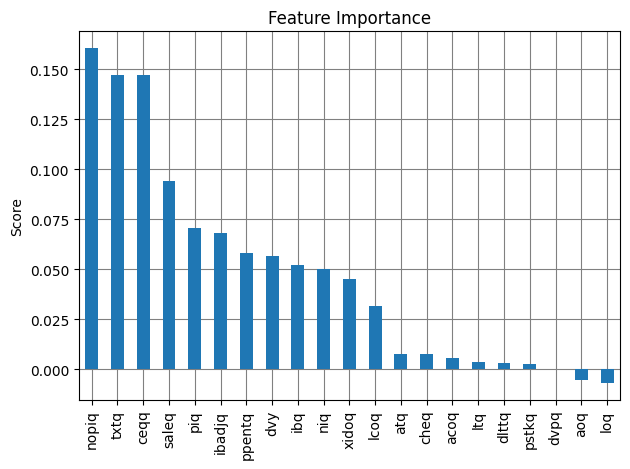

In [376]:
nn2 = nn2_importances_1 /(nn2_importances_1.sum())
fig, ax2 = plt.subplots()
nn2.plot.bar(ax=ax2)
ax2.set_axisbelow(True)
ax2.grid(color='gray')
ax2.set_title('Feature Importance')
ax2.set_ylabel('Score')
fig.tight_layout()
plt.show()